# Time-series analysis and forecasting 
In this notebook, we will try to forecast / predict aggregate sales for a chosen family of products (or aggregate for all products) sold at Favorita stores located in Ecuador. 

**File Descriptions and Data Field Information**

**train.csv**
* The training data, comprising time series of features **family**, and **onpromotion** as well as the target **sales**.

* **store_nbr** identifies the store at which the products are sold.

* **family** identifies the type of product sold.

* **sales** gives the total sales for a product family at a given date. 

* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

**oil.csv**
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**
* Holidays and Events, with metadata

**Additional Notes**
* Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

**Methodology** 

We will make 2-stage predictions in this notebook: 1st stage will be using a linear model, which does well in learning trends and extrapolating output, to make the 1st prediction. The residuals (actual - predicted) from the first prediction should likely remove any trend observed in the underlying data and thereby make the residuals time-series relatively more stationary than the target variable, sales. After adding necessary lag-related features derived from residuals series to our training data, we will run our 2nd model, Gradient Boosting Regression, which does well interpolating output from stationary data, to predict the residuals we got from the 1st model. We will then add the 1st sales prediction and 2nd residual prediction to obtain our final sales prediction. At each stage, we will evaluate the efficacy of our model using two metrics: Root Mean Squared Error (RMSE), and Mean Squared Log Error (MSLE). And of course, we will plot the predictions against true values to  visualize how aligned our predictions are to the actual target values. 

**Note:** In the course of developing this Notebook, I have tried numerous combinations of features that address trend, seasonality, and correlation between variables, and have included here only that combination which has produced the best performance metrics so far. 

In [86]:
# Importing libraries and files 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
import seaborn as sns 

import gc 
gc.collect() 

import warnings
warnings.filterwarnings("ignore")

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import * 
from learntools.time_series.style import *  # plot style settings

pd.set_option('display.max_rows', 300) 
pd.set_option('display.max_columns', 75) 
sns.set_style("whitegrid") 

# Set random seed 
SEED = np.random.default_rng().integers(999999)
# SEED = 999999 # 999999 
set_random_seed = SEED
print('SEED:', SEED) 

SEED: 931063


In [87]:
# Setup notebook
from pathlib import Path
comp_dir = Path('../input/store-sales-time-series-forecasting') 

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    parse_dates=['date'],
    index_col='date').to_period('D')

store_sales = pd.read_csv(comp_dir/'train.csv', dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', }, parse_dates=['date']).drop('id', axis=1) 
store_sales['date'] = store_sales.date.dt.to_period('D') 
transactions = pd.read_csv(comp_dir/'transactions.csv', parse_dates=['date'], index_col='date').to_period('D') 
stores = pd.read_csv(comp_dir/'stores.csv', dtype={'store_nbr': 'category'}) 
oil = pd.read_csv(comp_dir/'oil.csv', parse_dates=['date'], index_col='date').to_period('D') 

In [88]:
# # inspecting datasets 
# df_list = [store_sales, transactions, oil, holidays_events]
# df_names = ['store_sales', 'transactions', 'oil', 'holidays_events', ]

# for (df, name) in zip (df_list, df_names): 
#     df.name = name 

# for df in df_list: 
#     print('\n---------', df.name, '---------') 
#     print(df.info(), df.head(), df.tail(), df.describe(include='all'), sep='\n') 

In [89]:
# cleaning holiday events df to use for modeling  
holidays_events.describe(include='all')

# for col in holidays_events.columns: 
#     print(col, holidays_events[col].unique()) 
holidays_events = holidays_events.query("type != 'Work Day' & description.str.contains('Puente') != True") 
# holidays_events = holidays_events.query("type != 'Work Day'") 

for txt in ['Puente ', 'Traslado ', '-1', '-2', '-3', '-4', ] + ['+'+str(i) for i in range(30, 0, -1)]: 
    holidays_events['description'] = holidays_events.description.str.replace(txt, '')

holidays_events['holi_val'] = 1 

# "Terremoto Manabi: In the plot for Sales for the Months of April and May 2016, there appears to be 2 waves of surge in Sales post the Earthquake at Manabi - So, to address this, have included 2 separate sine cycles for relevant dates in Apr and May"
holidays_events.loc[(holidays_events.description=='Terremoto Manabi') & (holidays_events.index < "2016-04-28"), ['description', 'holi_val']] = [['Terremoto_Manabi_Apr', np.sin(i*np.pi/12)] for i in range(1,13) ]
holidays_events.loc[(holidays_events.description=='Terremoto Manabi') & (holidays_events.index >= "2016-04-28"), ['description', 'holi_val']] = [['Terremoto_Manabi_May', np.sin(i*np.pi/19)] for i in range(1,20) ] 
holi_pivot = holidays_events.pivot_table(index=holidays_events.index, columns='description', values='holi_val').fillna(0.0)

In [90]:
# Sorting product family by proportion of total sales to see which products account of most of Sales 
pt = store_sales.pivot_table(index='family', values='sales', aggfunc='sum', margins=True)
print("Sales proportion of each product family sorted in descending order:")
display(pt.div(pt.loc['All']).sort_values('sales', ascending=False).T )

# aggregating store_sales by family and date to enable selection for further analysis 
store_sales = store_sales.pivot_table(index = ['family', 'date'], values= ['sales', 'onpromotion',], aggfunc=np.mean ).reset_index() 

# Adding aggregate Sales as a family (category) so we can try to predict date-wise all product sales if we so wish 
all_sales = store_sales.pivot_table(index = ['date'], values= ['sales', 'onpromotion',], aggfunc=np.mean ).reset_index() 
all_sales['family'] = 'AllProds' 
store_sales = pd.concat([store_sales, all_sales], axis=0) 

families = ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD', 'AllProds']

# Choosing family of products to predict sales using our model 
fam = 'BEVERAGES' 
product_sales = store_sales.loc[store_sales.family.isin([fam]) ].drop(['family'], axis=1).set_index('date') 

Sales proportion of each product family sorted in descending order:


family,All,GROCERY I,BEVERAGES,PRODUCE,CLEANING,DAIRY,BREAD/BAKERY,POULTRY,MEATS,PERSONAL CARE,DELI,HOME CARE,EGGS,FROZEN FOODS,PREPARED FOODS,"LIQUOR,WINE,BEER",SEAFOOD,GROCERY II,HOME AND KITCHEN I,HOME AND KITCHEN II,CELEBRATION,LINGERIE,LADIESWEAR,PLAYERS AND ELECTRONICS,AUTOMOTIVE,LAWN AND GARDEN,PET SUPPLIES,BEAUTY,SCHOOL AND OFFICE SUPPLIES,MAGAZINES,HARDWARE,HOME APPLIANCES,BABY CARE,BOOKS
sales,1.0,0.319903,0.202073,0.114288,0.090832,0.060064,0.039244,0.02969,0.028954,0.022905,0.022457,0.014924,0.014519,0.013109,0.008196,0.007215,0.001877,0.001828,0.001734,0.001416,0.000709,0.000608,0.000606,0.000524,0.000517,0.000511,0.000332,0.000315,0.000251,0.000248,0.000096,0.000039,0.000009,0.000006


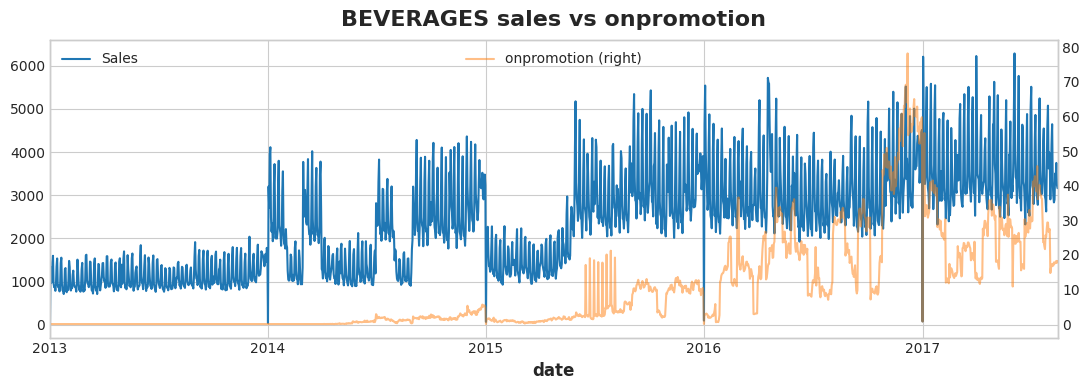

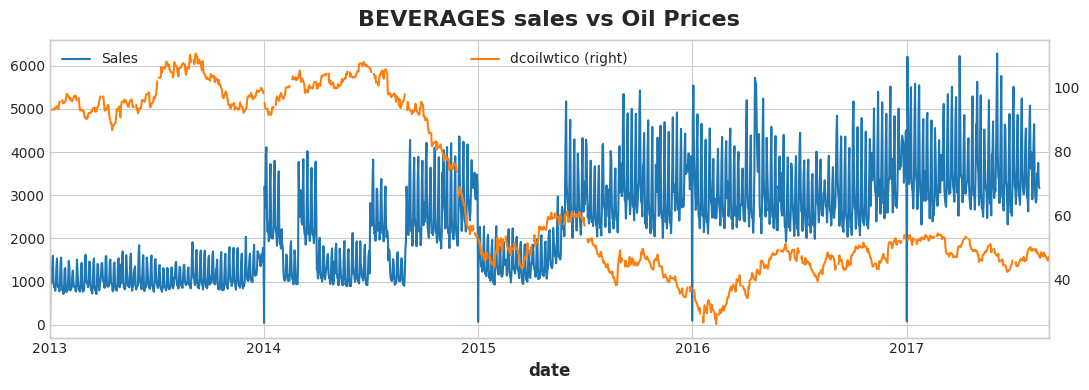

In [91]:
# Visualizing sales vs other time series in the dataset 
product_sales.sales.plot(label='Sales').set(title=fam +' sales vs onpromotion'); plt.legend()
product_sales.onpromotion.plot(secondary_y=True, label='onpromotion', alpha=0.5); plt.legend(loc='upper center')
plt.tight_layout() 

plt.subplots()
product_sales.sales.plot(label='Sales').set(title=fam +' sales vs Oil Prices'); plt.legend()
oil.dcoilwtico.plot(secondary_y=True, label='dcoilwtico'); plt.legend(loc='upper center'); plt.tight_layout()

The plot for our target variable, Sales, indicates a mostly upward trend. The plot for our target variable, Sales, indicates a mostly upward trend. It also appears that the big drop in Oil Prices by mid-2014 to early-2015 had a deflationary effect on sales in the 1st few months of 2015


In [92]:
# Checking the stationarity of time series 
from statsmodels.tsa.stattools import adfuller 
print('AD Fuller test results for time series: ')
print('sales:', adfuller(product_sales.sales, regression='ct') ) 

# adfs = [(adfuller(product_sales.sales.shift(x).dropna())[1].round(2), x ) for x in range(400) ] 
# print(sorted([x for x in adfs if x[0] >= 0.05], reverse=True))

AD Fuller test results for time series: 
sales: (-5.3187677552254335, 5.201022389317206e-05, 22, 1661, {'1%': -3.964230724633873, '5%': -3.4131365120665933, '10%': -3.128608080160255}, 24789.529774893737)


The AD Fuller shows pvalue for our test statistic which is much lower than critical 1% pvalue, which means AD Fuller test failed to prove stationarity of the data. In simple words, the AD Fuller test establishes that target variable, sales, is a non-stationary time-series. Therefor, we need to include lag-related features in our data to account for its inherent trend. 


Seasonal Decompose for Sales: seasonality-trend-constant-error-actual plots


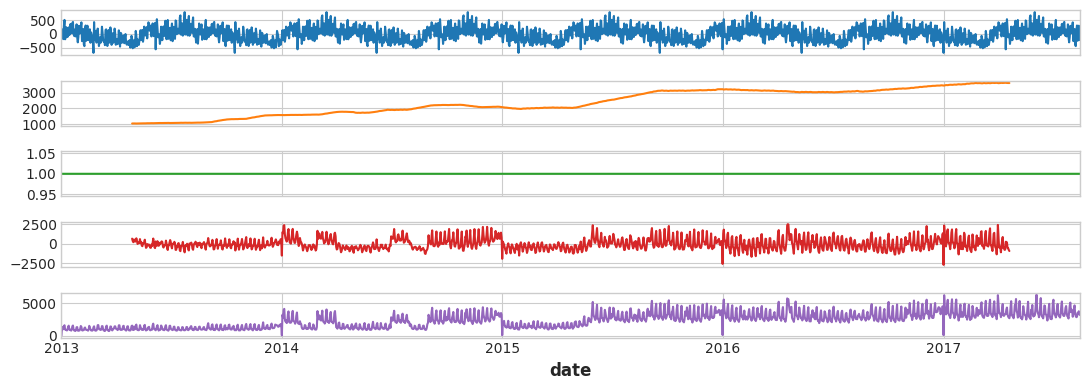

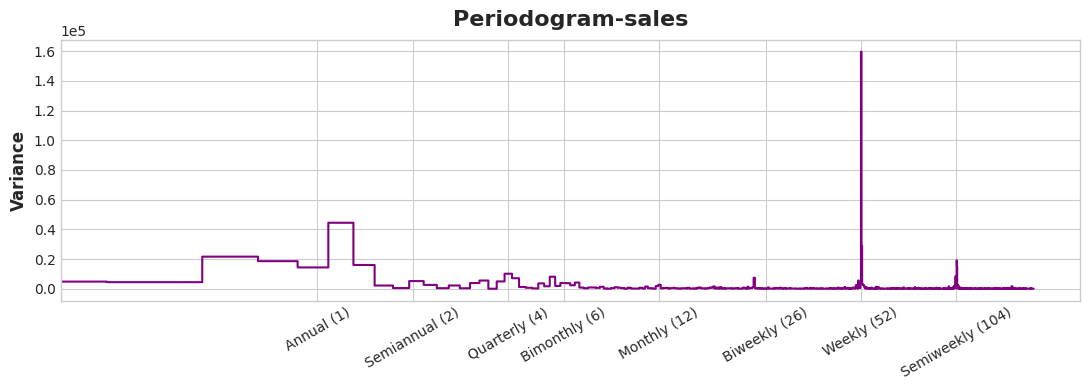

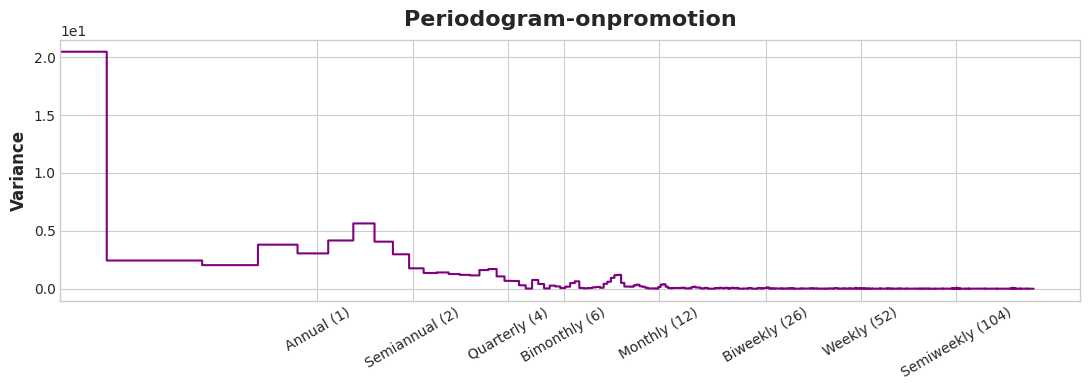

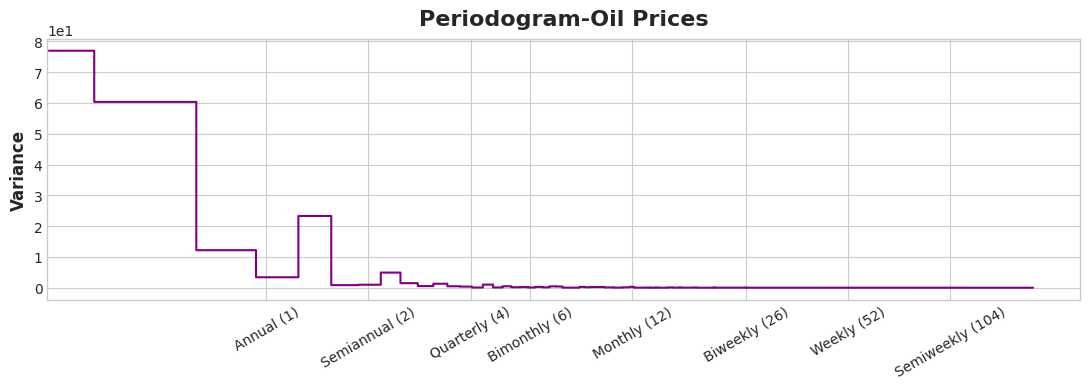

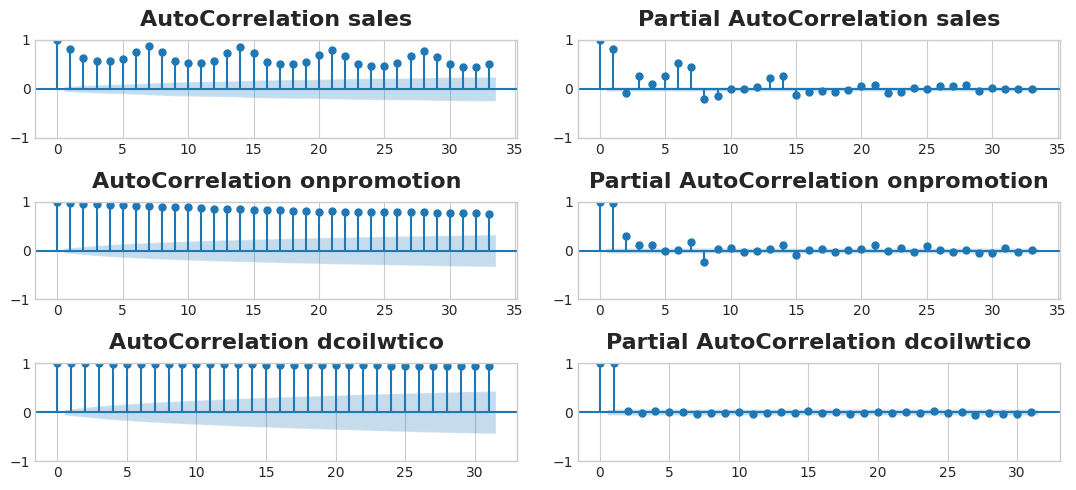

In [108]:
# Let us also plot values for Seasonal_decompose, ACF, PACF, and Periodogram to explore further 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from learntools.time_series.utils import plot_periodogram

print('Seasonal Decompose for Sales: seasonality-trend-constant-error-actual plots')
pd.DataFrame(seasonal_decompose(product_sales.sales, period=234).__dict__).plot(subplots=True);

plot_periodogram(product_sales.sales).set(title='Periodogram-sales')
plot_periodogram(product_sales.onpromotion).set(title='Periodogram-onpromotion') 
plot_periodogram(oil.dcoilwtico.dropna()).set(title='Periodogram-Oil Prices') 
plt.tight_layout() 

fig, ax = plt.subplots(3,2, figsize=(11,5))
for x, ts in enumerate([product_sales.sales, product_sales.onpromotion, oil.dcoilwtico.dropna()]): 
    plot_acf(ts, title='AutoCorrelation '+ts.name, ax=ax[x][0]) 
    plot_pacf(ts, title='Partial AutoCorrelation '+ts.name, ax=ax[x][1]) 
plt.tight_layout() 

Periodogram indicates dominant seasonality at weekly frequency for Sales & onpromotion, and about annual frequency for Oil prices. Note well that the scale of variance in the Periodogram is negligible for onpromotion and oil price, but much higher for Sales. So, we should probably focus mostly on addressing seasonality in the target variable Sales. 

The wave-like ACF plot for Sales also hints at repeating weekly cycles. But it appears there are other cyclical frequencies (as apparent in the Periodogram) also at play so we should incorporate features that address such multiple seasonal frequencies. 

In [94]:
# creating trend and seasonality indicators using date / period index 
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess 

fourier = [CalendarFourier(freq='W', order=2), CalendarFourier(freq='6W', order=1), CalendarFourier(freq='3W', order=1), CalendarFourier(freq='Y', order=1), CalendarFourier(freq='4M', order=1), CalendarFourier(freq='6M', order=2), CalendarFourier(freq='7M', order=1), CalendarFourier(freq='8M', order=1), CalendarFourier(freq='9M', order=1), CalendarFourier(freq='10M', order=1), CalendarFourier(freq='11M', order=1) ]
dp = DeterministicProcess(index=store_sales.date.unique(), constant=True, order=1, seasonal=True, drop=True, additional_terms=fourier) 
trend_season_train = dp.in_sample() 

In [95]:
# merge relevant data from all dfs into a single df for further manipulation 
combined_train = trend_season_train.merge(oil, how='left', left_index=True, right_index=True, validate="many_to_one")
combined_train = combined_train.merge(holi_pivot, how='left', left_index=True, right_index=True) 
combined_train = product_sales.merge(combined_train, how='left', left_index=True, right_index=True, validate="many_to_one")

combined_train.dcoilwtico.fillna(method='ffill', inplace=True) # using previous available oil price to fill NaNs 
combined_train.dcoilwtico.fillna(method='bfill', inplace=True) # using backfill only for 1st day of the series, ie. 1Jan2013 
combined_train.replace(np.nan, 0.0, inplace=True) 

# combined_train.info() 
# combined_train.isna().sum()

In [96]:
# create lagged, differenced and moving aggregate series of target variable to address trend and seasonality in data 
print('shape before adding lag-related features:', combined_train.shape)

test_size = 30 # need to define number of days in the test set at this stage since lag features need to account for test days in order to allow sufficient lead days so there are no NA values in lag features in the test set 
lead_days = int(np.ceil(test_size/7) * 7) if test_size%7 else test_size # the next higher multiple of 7 (i.e. weekly freq) above the test_size 
lags = [*range(1,8),14,27,42,49,56,60,120,234,310,345,365, ] 

for x in lags: 
    combined_train['sales-'+str(lead_days + x)] = combined_train['sales'].shift(lead_days + x)
    combined_train['sales-'+str(lead_days)+'_diff'+str(x)] = combined_train['sales'].shift(lead_days).diff(x)

sales_n = [7, 234, 365] # moving aggregate for various periods (no of days) to clarify trend period-over-period 
for x in sales_n: 
    combined_train['sales-'+str(lead_days)+'_mvagg'+str(x)] = combined_train['sales'].shift(lead_days).rolling(x).mean() 
print('shape after adding sales lag-related features:', combined_train.shape) 

# create lag-releated features of other variables 
oil_lags = [365,]
for x in oil_lags: 
    combined_train['dcoilwtico-'+str(lead_days)+'_diff'+str(x)] = combined_train['dcoilwtico'].shift(lead_days).diff(x)
combined_train['dcoilwtico-'+str(lead_days)] = combined_train['dcoilwtico'].shift(lead_days) 
    
promo_n = [14,] # we need not consider lead time for onpromotion values since promotion program is decided by the company, so is known before hand and need not be forecasted. 
for x in promo_n: 
    combined_train['onpromotion'+'_mvagg'+str(x)] = combined_train['onpromotion'].rolling(x).mean() 
print('shape after adding other lag-related features:', combined_train.shape) 

combined_train = combined_train.dropna() 
print('shape after dropping NA values resulting from time-series shifting above:', combined_train.shape) 

shape before adding lag-related features: (1684, 86)
shape after adding sales lag-related features: (1684, 125)
shape after adding other lag-related features: (1684, 128)
shape after dropping NA values resulting from time-series shifting above: (1284, 128)


In [97]:
# split data into features(X), target sales(y), train and test datasets 
test_size = test_size # previously defined test_size or lower value to try (higher values will create NA values in test dataset lag-related columns since they are already defined based on pre-defined test_size)

X_train0 = combined_train.iloc[:-test_size].drop('sales', axis=1) 
y_train0 = combined_train.iloc[:-test_size][['sales']] 
X_test0 = combined_train.iloc[-test_size:].drop('sales', axis=1) 
y_test0 = combined_train.iloc[-test_size:][['sales']] 

In [98]:
# Scaling data before fitting a model 
from sklearn.preprocessing import StandardScaler, RobustScaler 

scaler = StandardScaler(with_mean=True)
# scaler = RobustScaler(with_centering=True) 

X_train0[:] = scaler.fit_transform(X_train0) 
X_test0[:] = scaler.transform(X_test0) 

print(X_train0.corrwith(y_train0.sales).dropna().sort_values(ascending=False).iloc[[*range(15)] + [*range(-15,0)]] )

sales-42               0.663736
sales-49               0.660813
sales-77               0.611463
trend                  0.582222
sales-84               0.571241
sales-91               0.566205
sales-62               0.556604
sales-35_mvagg365      0.551124
sales-35_mvagg234      0.525806
sales-41               0.518269
onpromotion            0.512071
sales-35_mvagg7        0.500332
onpromotion_mvagg14    0.500099
sales-36               0.491660
sales-35_diff3         0.408870
sin(1,freq=9ME)       -0.086937
sin(1,freq=8ME)       -0.087336
sin(1,freq=7ME)       -0.088359
sin(1,freq=6ME)       -0.089685
sin(1,freq=4ME)       -0.098490
sin(2,freq=6ME)       -0.110006
sin(2,freq=W-SUN)     -0.123173
s(6,7)                -0.134132
s(7,7)                -0.155537
sin(1,freq=YE-DEC)    -0.159045
cos(2,freq=W-SUN)     -0.215244
dcoilwtico-35         -0.417980
sin(1,freq=W-SUN)     -0.419683
cos(1,freq=3W-SUN)    -0.432612
dcoilwtico            -0.434620
dtype: float64


In [99]:
# running model to make 1st prediction
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_squared_log_error 

model = LinearRegression() 
model.fit(X_train0, y_train0.sales) 

y_train0['pred0'] = model.predict(X_train0)
y_train0['resid0'] = y_train0.sales - y_train0.pred0 
y_test0['pred0'] = model.predict(X_test0)
y_test0['resid0'] = y_test0.sales - y_test0.pred0 

print('metrics for 1st prediction: pred0 sales vs true sales ')
print('RMSE train:', mean_squared_error(y_train0.sales, y_train0.pred0.clip(lower=0.0), squared=False)) 
print('MSLE train:', mean_squared_log_error(y_train0.sales, y_train0.pred0.clip(lower=0.0) ) )
print('RMSE test:', mean_squared_error(y_test0.sales, y_test0.pred0.clip(lower=0.0), squared=False)) 
print('MSLE test:', mean_squared_log_error(y_test0.sales, y_test0.pred0.clip(lower=0.0) ) )

metrics for 1st prediction: pred0 sales vs true sales 
RMSE train: 466.3934576442149
MSLE train: 0.061462462051405715
RMSE test: 664.1682171146864
MSLE test: 0.029566116450238825


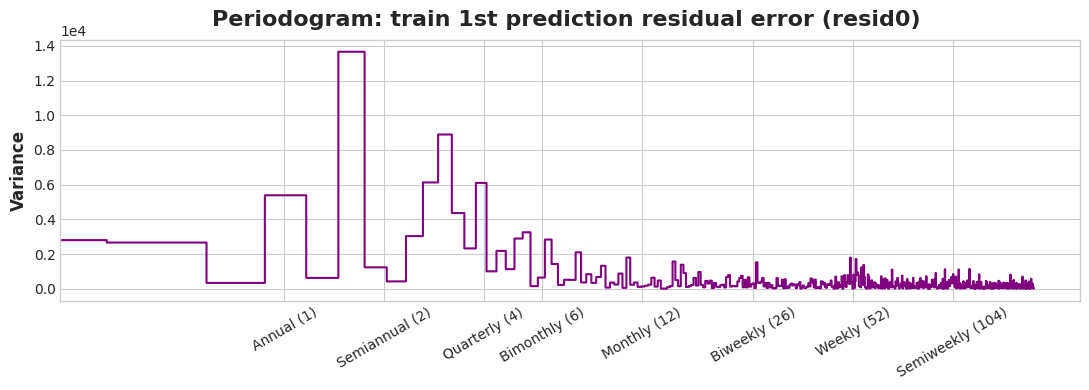

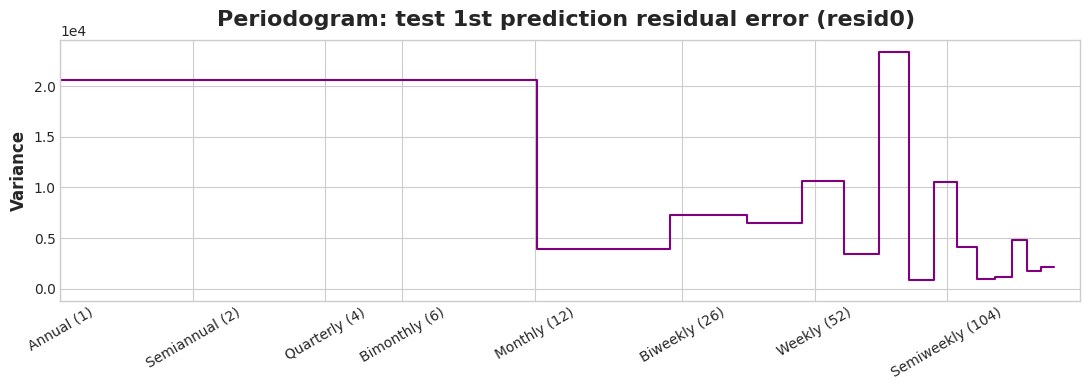

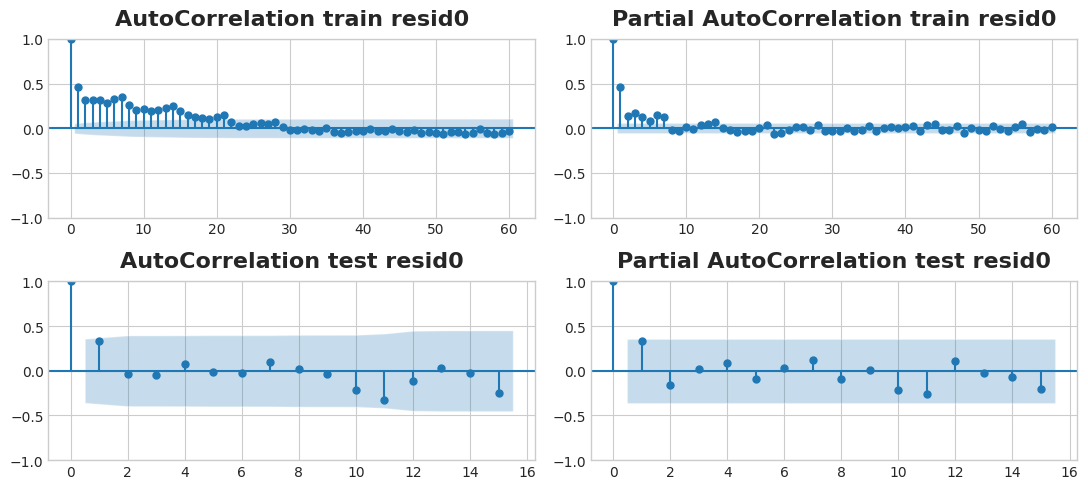

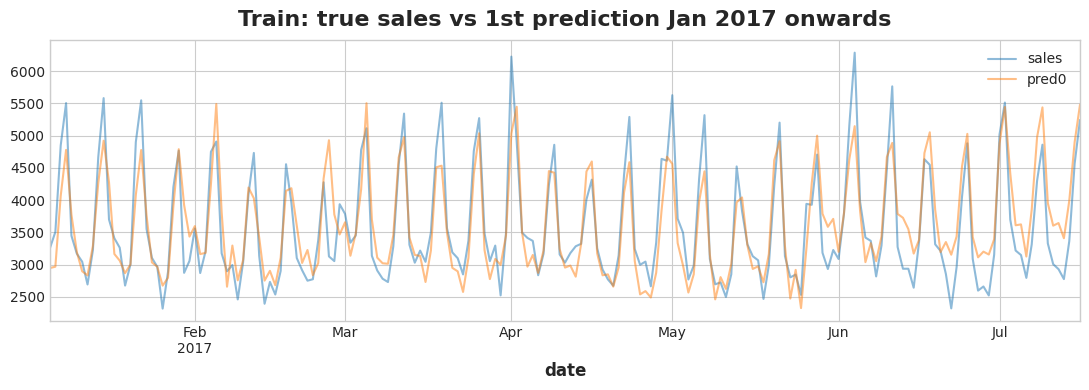

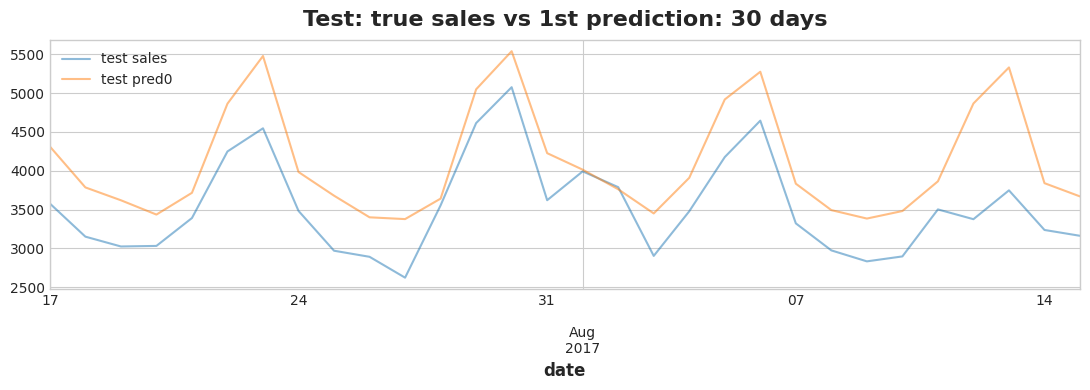

In [100]:
# Visualizing results from 1st prediction 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from learntools.time_series.utils import plot_periodogram

plot_periodogram(y_train0.resid0).set(title='Periodogram: train 1st prediction residual error (resid0) ') 
plot_periodogram(y_test0.resid0).set(title='Periodogram: test 1st prediction residual error (resid0) ') 

fig, ax = plt.subplots(2,2, figsize=(11,5))
for x, ts in enumerate([y_train0.resid0, y_test0.resid0]): # y_train0.pred0, 
    title_str = 'train ' if x==0 else 'test '
    plot_lags= 60 if x==0 else None
    plot_acf(ts, lags=plot_lags, title='AutoCorrelation '+title_str+ts.name, ax=ax[x][0]) 
    plot_pacf(ts, lags=plot_lags, title='Partial AutoCorrelation '+title_str+ts.name, ax=ax[x][1]) 
plt.tight_layout()

plt.subplots()
y_train0.sales.loc['01-05-2017':].plot(label='sales', alpha=0.5, ).set(title='Train: true sales vs 1st prediction Jan 2017 onwards')
y_train0.pred0.loc['01-05-2017':].plot(label='pred0', alpha=0.5); plt.legend(); plt.tight_layout() 

plt.subplots()
y_test0.sales.plot(label='test sales', alpha=0.5, ).set(title='Test: true sales vs 1st prediction: {} days'.format(test_size))
y_test0.pred0.plot(label='test pred0', alpha=0.5); plt.legend(); plt.tight_layout() 

When comparing the periodogram for target, Sales, and 1st prediction residuals (resid0), we see that the scale of variance has markedly reduced and hence we can consider the residual series being more stationary and therefore fitter for making predictions with a Gradient Boosting Model. The relatively flatter ACF and PACF plots for the 2 series also show this transformation. 

We will now add some lag-related features based on the residuals to address any remaining variability in the data so Gradient Boosting model can improve our prediction. 

In [101]:
# combine datasets to include additional lag-related features on residuals series before splitting again 
temp_X = pd.concat([X_train0, X_test0], axis=0) 
temp_y = pd.concat([y_train0, y_test0], axis=0) 
combined_train1 = pd.concat([temp_X, temp_y], axis=1) 

In [102]:
# create lagged, differenced and moving aggregate series of 1st prediction residuals 
print('shape before adding lag-related features:', combined_train1.shape)

test_size = test_size # preferably kept same as pre-defined test_size 
lead_days = int(np.ceil(test_size/7) * 7)  # the next higher multiple of 7 (i.e. weekly freq) above the test_size 
lags = lags # [*range(1,8),14,27,42,49,56,60,120,234,310,345,365 ]  

for x in lags: 
    combined_train1['resid0-'+str(lead_days + x)] = combined_train1['resid0'].shift(lead_days + x)
    combined_train1['resid0-'+str(lead_days)+'_diff'+str(x)] = combined_train1['resid0'].shift(lead_days).diff(x)

resid0_n = [7, 21, 234, 365] # moving aggregate for various periods (no of days) to clarify trend period-over-period 
for x in resid0_n: 
    combined_train1['resid0-'+str(lead_days)+'_mvagg'+str(x)] = combined_train1['resid0'].shift(lead_days).rolling(x).mean() 

combined_train1 = combined_train1.dropna() 
print('shape after adding resid0 lag-related features:', combined_train1.shape) 
print('shape after dropping NA values resulting from time-series shifting above:', combined_train1.shape) 

shape before adding lag-related features: (1284, 130)
shape after adding resid0 lag-related features: (884, 170)
shape after dropping NA values resulting from time-series shifting above: (884, 170)


In [103]:
# split data into features(X), target residuals(y), train and test datasets for further processing before 2nd prediction 
test_size = test_size # previously defined test_size or lower value to try (higher values will create NA values in test dataset lag-related columns since they are already defined based on pre-defined test_size)

X_train1 = combined_train1.iloc[:-test_size].drop(['sales', 'pred0', 'resid0'], axis=1) 
y_train1 = combined_train1.iloc[:-test_size][['sales', 'pred0', 'resid0']] 
X_test1 = combined_train1.iloc[-test_size:].drop(['sales', 'pred0', 'resid0'], axis=1) 
y_test1 = combined_train1.iloc[-test_size:][['sales', 'pred0', 'resid0']] 

In [104]:
# Scaling data before fitting a model 
from sklearn.preprocessing import StandardScaler, RobustScaler 

scaler = StandardScaler(with_mean=True)
# scaler = RobustScaler(with_centering=True) 

X_train1[:] = scaler.fit_transform(X_train1) 
X_test1[:] = scaler.transform(X_test1) 

print(X_train1.corrwith(y_train1.sales).dropna().sort_values(ascending=False).iloc[[*range(15)] + [*range(-15,0)]] )

sales-42              0.690790
sales-49              0.678134
sales-77              0.631169
sales-91              0.578981
sales-84              0.572717
sales-35_diff234      0.537421
sales-35_diff345      0.529716
sales-62              0.522453
sales-35_diff3        0.517481
sales-35_diff4        0.510977
sales-35_diff60       0.510596
sales-35_diff365      0.507242
sales-35_diff310      0.486694
sales-41              0.482731
sales-35_diff120      0.473794
sin(1,freq=11ME)     -0.127296
sin(1,freq=10ME)     -0.127743
sin(1,freq=9ME)      -0.128405
sin(1,freq=8ME)      -0.128947
sin(1,freq=7ME)      -0.129802
sin(1,freq=6ME)      -0.131184
s(5,7)               -0.136099
sin(1,freq=4ME)      -0.139800
sin(2,freq=6ME)      -0.151664
sin(2,freq=W-SUN)    -0.155223
s(7,7)               -0.205525
s(6,7)               -0.206173
cos(2,freq=W-SUN)    -0.263476
sin(1,freq=W-SUN)    -0.526616
cos(1,freq=3W-SUN)   -0.543585
dtype: float64


In [105]:
# running model to predict residuals from 1st prediction; then adding 1st prediction & predicted residuals to calculate final (2nd) prediction 

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, mean_squared_log_error 

# running model to make 2nd prediction
model = GradientBoostingRegressor(random_state=SEED) 
model.fit(X_train1, y_train1.resid0) 

y_train1['residp1'] = model.predict(X_train1)
y_train1['pred1'] = y_train1.pred0 + y_train1.residp1 
y_train1['resid1'] = y_train1.sales - y_train1.pred1 

y_test1['residp1'] = model.predict(X_test1)
y_test1['pred1'] = y_test1.pred0 + y_test1.residp1 
y_test1['resid1'] = y_test1.sales - y_test1.pred1 

print('metrics for 2nd prediction: pred1 sales vs true sales ')
print('RMSE train:', mean_squared_error(y_train1.sales, y_train1.pred1.clip(lower=0.0), squared=False)) 
print('MSLE train:', mean_squared_log_error(y_train1.sales, y_train1.pred1.clip(lower=0.0) ) )
print('RMSE test:', mean_squared_error(y_test1.sales, y_test1.pred1.clip(lower=0.0), squared=False)) 
print('MSLE test:', mean_squared_log_error(y_test1.sales, y_test1.pred1.clip(lower=0.0) ) ) 

metrics for 2nd prediction: pred1 sales vs true sales 
RMSE train: 215.69684264278538
MSLE train: 0.010785799984759155
RMSE test: 397.51096775204644
MSLE test: 0.009276545970821283


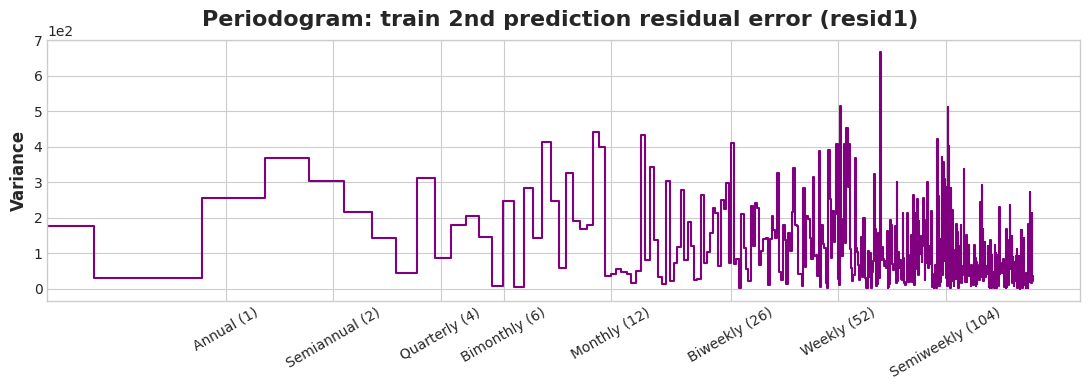

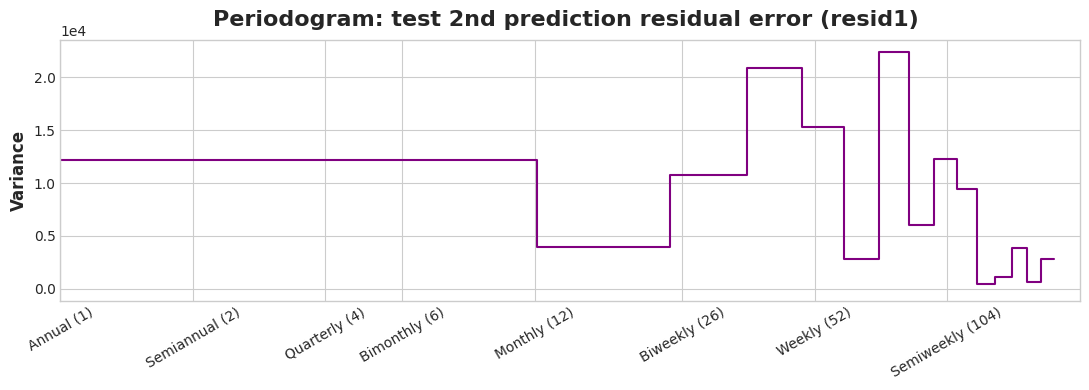

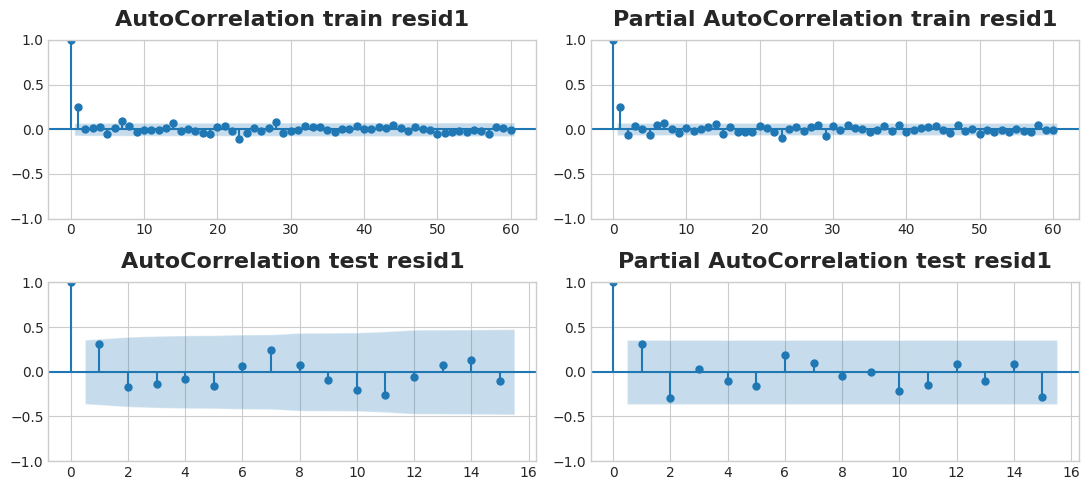

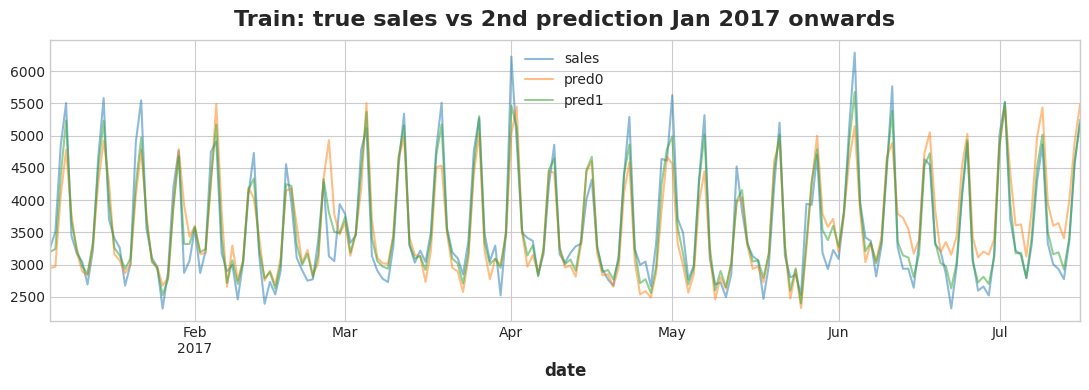

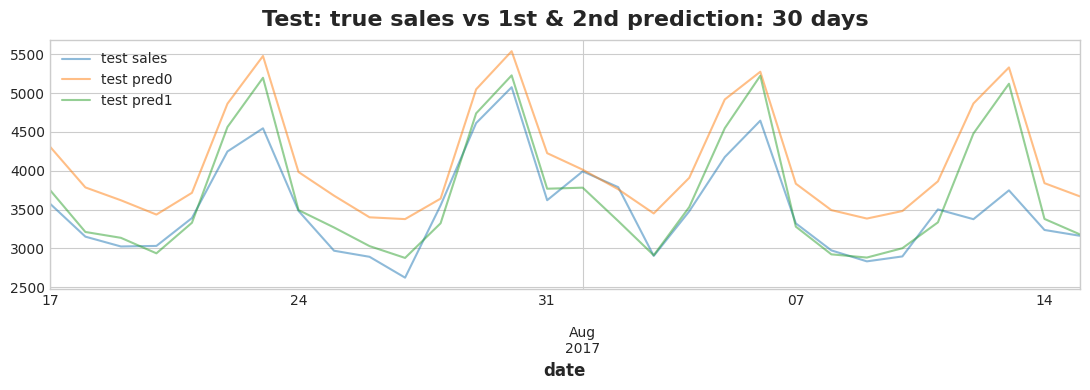

In [106]:
# Visualizing results from 2nd prediction 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from learntools.time_series.utils import plot_periodogram

plot_periodogram(y_train1.resid1).set(title='Periodogram: train 2nd prediction residual error (resid1) ') 
plot_periodogram(y_test1.resid1).set(title='Periodogram: test 2nd prediction residual error (resid1) ') 

fig, ax = plt.subplots(2,2, figsize=(11,5))
for x, ts in enumerate([y_train1.resid1, y_test1.resid1]): # y_train1.pred1, 
    title_str = 'train ' if x==0 else 'test '
    plot_lags= 60 if x==0 else None
    plot_acf(ts, lags=plot_lags, title='AutoCorrelation '+title_str+ts.name, ax=ax[x][0]) 
    plot_pacf(ts, lags=plot_lags, title='Partial AutoCorrelation '+title_str+ts.name, ax=ax[x][1]) 

plt.subplots()
y_train1.sales.loc['01-05-2017':].plot(label='sales', alpha=0.5, ).set(title='Train: true sales vs 2nd prediction Jan 2017 onwards')
y_train1.pred0.loc['01-05-2017':].plot(label='pred0', alpha=0.5);
y_train1.pred1.loc['01-05-2017':].plot(label='pred1', alpha=0.5); plt.legend(); plt.tight_layout() 

plt.subplots()
y_test1.sales.plot(label='test sales', alpha=0.5, ).set(title='Test: true sales vs 1st & 2nd prediction: {} days'.format(test_size))
y_test1.pred0.plot(label='test pred0', alpha=0.5); 
y_test1.pred1.plot(label='test pred1', alpha=0.5); plt.legend(); plt.tight_layout() 

**Conclusion:** 

Comparing the metrics between our 1st (pred0) and 2nd (pred1) predictions, we note there is a very large improvement for the training set, which is not surprising since tree based models (which makes up the Gradient Boosting model) tend to overfit when used to make predictions on training data. The real test is how good the improvement is in the test set. And we see that the test prediction metrics have also improved reasonably and with the various combinations of features I have tried in this Notebook, they are the best so far, and show almost similar improvement when trying with different family of products. So, I can safely assume that the model is generalizing well to unseen data. 

The plot comparing true sales vs 1st and 2nd predictions for the test set also shows that we have reduced the gap between 1st prediction and Sales with our 2nd prediction. The ACF and PACF plots for 2nd residual show that almost all values within the 95% confidence interval and the residuals we are now left with may be close to random noise which cannot be modeled or predicted. 

The scale of variance in the periodogram for 2nd residuals (True sales - 2nd prediction pred1) has come down to single digit numbers from about 10000's in the true Sales series periodogram. This too hints at an almost de-seasoned series like random-noise. 

With this, we will end our analysis here. Of course, there are still many ways to improve our prediction and metrics by tuning model hyper-parameters and trying other models such as xgboost, or neural networks. But since my objective when starting this project was to focus more on developing features that are peculiar to a time-series and from that obtain a sensible prediction, with the results that I see here, I think that objective has been reasonably fulfilled. So, it's a wrap for now. 

Thanks for your time reading this work.
😀